In [2]:
# =====================================================================
# HMIS Complete State-wise Analysis Pipeline (10 States)
# =====================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score, davies_bouldin_score, calinski_harabasz_score, 
    accuracy_score, classification_report, confusion_matrix,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb
from scipy.cluster.hierarchy import linkage, dendrogram
import joblib

sns.set_theme()
plt.rcParams["figure.figsize"] = (10, 6)


In [3]:
# ======================== DATA LOADING & PREPROCESSING ========================
file_path = "C:/Users/91971/Desktop/22070521036_Arya_Kashikar_HIMS_DataScience_Project/dataset/HMIS_Cleaned.csv"
state_col = "State"
os.makedirs("models", exist_ok=True)
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip()
states = [
    "Kerala", "Tamil Nadu", "Maharashtra", "Gujarat", "Karnataka",
    "Rajasthan", "Uttar Pradesh", "Madhya Pradesh", "Bihar", "West Bengal"
]
df = df[df[state_col].isin(states)].copy()
features = [
    'Number_Of_Lab_Tests_Done__(UOM:Number),_Scaling_Factor:1',
    'Number_Of_Allopathic_Outpatient_Attendance__(UOM:Number),_Scaling_Factor:1',
    'Number_Of_Condom_Pieces_Distributed_(UOM:Number),_Scaling_Factor:1',
    'Number_Of_Haemoglobin_(Hb)_Tests_Conducted__(UOM:Number),_Scaling_Factor:1',
    'Patients_Registered_At_Emergency_Department_(UOM:Number),_Scaling_Factor:1',
    'In-Patient_Head_Count_At_Midnight_(UOM:Number),_Scaling_Factor:1'
]
df = df.dropna(subset=features + ['Month'])

In [4]:
# ================= AGGREGATE MONTHLY FOR EACH STATE =================
df['YearMonth'] = pd.to_datetime(df['Month'], format='%B, %Y', errors='coerce')
df_grouped = df.groupby([state_col, 'YearMonth'])[features].sum().reset_index()

# ======================= FEATURE SCALING =============================
X = df_grouped[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "models/scaler.joblib")

['models/scaler.joblib']

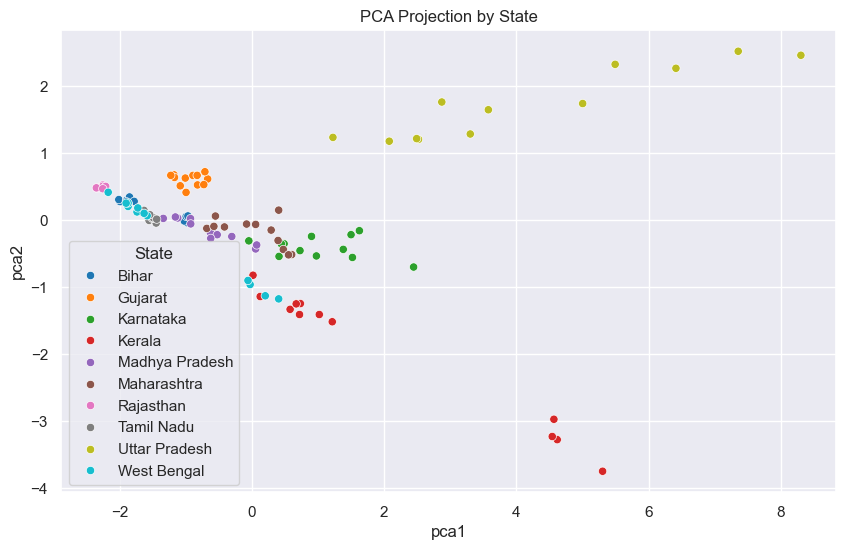

In [5]:
# =========================== PCA VISUALIZATION ========================
pca = PCA(n_components=2, random_state=42)
pca_coords = pca.fit_transform(X_scaled)
df_grouped['pca1'] = pca_coords[:, 0]
df_grouped['pca2'] = pca_coords[:, 1]
plt.figure()
sns.scatterplot(x='pca1', y='pca2', hue=state_col, data=df_grouped, palette="tab10")
plt.title("PCA Projection by State")
plt.show()

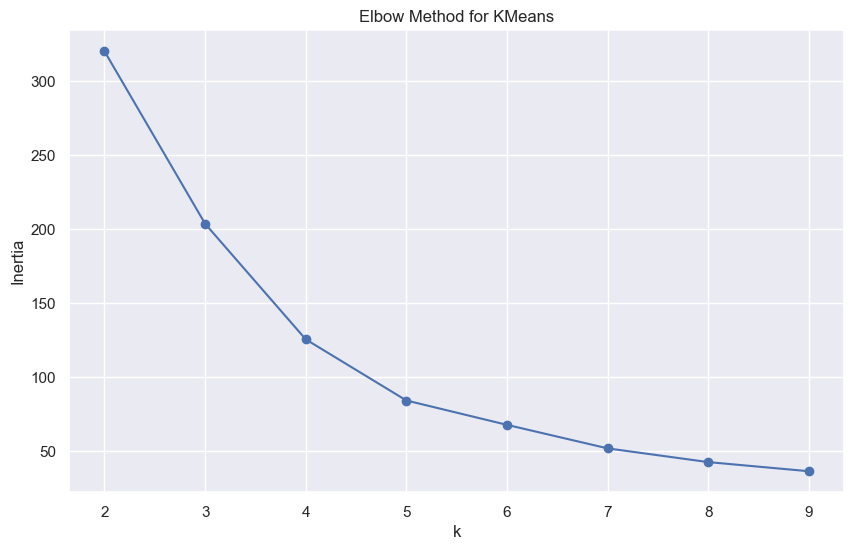

In [6]:
# ============================= ELBOW METHOD ===========================
inertias = []
for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42, n_init=20).fit(X_scaled)
    inertias.append(km.inertia_)
plt.figure()
plt.plot(range(2,10), inertias, 'bo-')
plt.title("Elbow Method for KMeans")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.show()


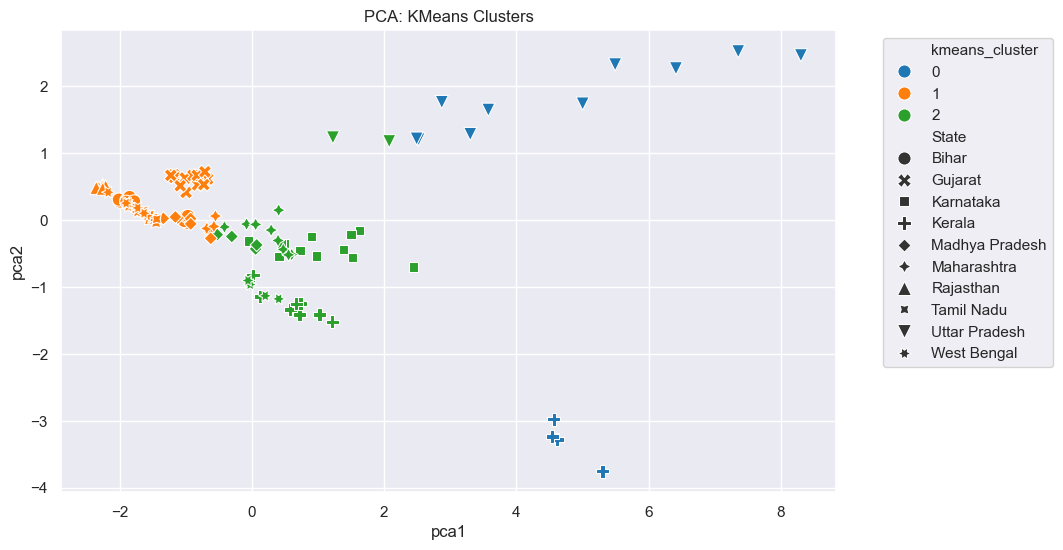

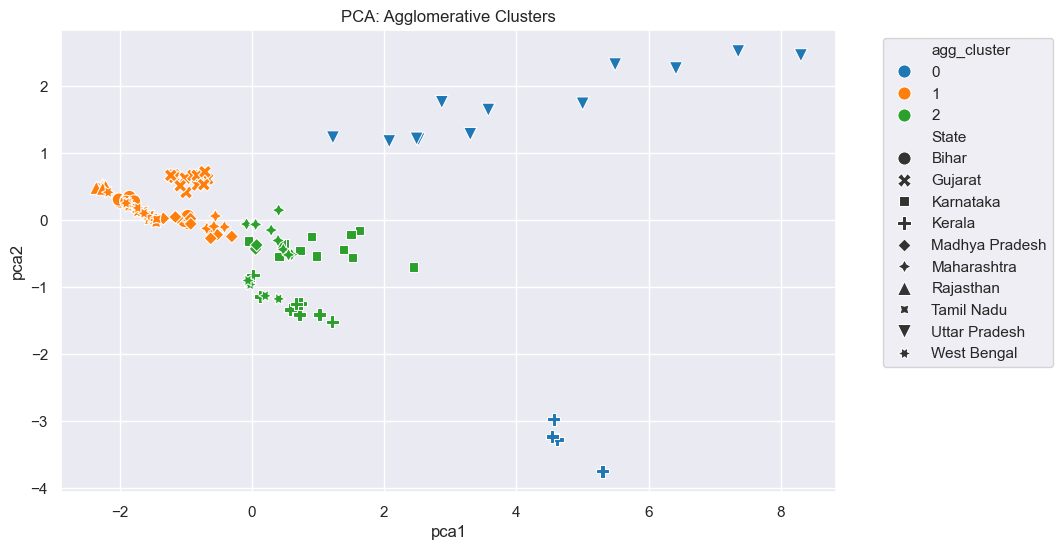

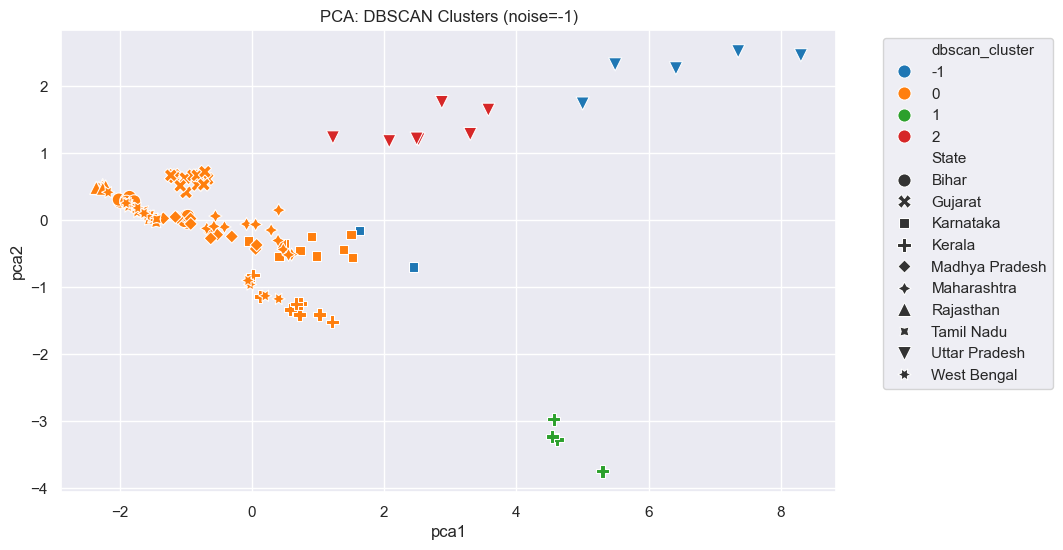

In [7]:
# ================= KMEANS, AGGLOMERATIVE, DBSCAN CLUSTERING ===========
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
df_grouped['kmeans_cluster'] = kmeans.fit_predict(X_scaled)
agg = AgglomerativeClustering(n_clusters=3)
df_grouped['agg_cluster'] = agg.fit_predict(X_scaled)
db = DBSCAN(eps=0.9, min_samples=4)
df_grouped['dbscan_cluster'] = db.fit_predict(X_scaled)

def plot_pca_colored(df, cluster_col, title):
    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df, x='pca1', y='pca2', hue=cluster_col, style=state_col, s=90, palette='tab10')
    plt.title(title)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()
plot_pca_colored(df_grouped, 'kmeans_cluster', "PCA: KMeans Clusters")
plot_pca_colored(df_grouped, 'agg_cluster', "PCA: Agglomerative Clusters")
plot_pca_colored(df_grouped, 'dbscan_cluster', "PCA: DBSCAN Clusters (noise=-1)")

In [8]:
# ======== CLUSTER METRICS (SILHOUETTE, DBI, CHI) ========
print("\nCluster Evaluation Metrics:")
for method, labels in [
    ("KMeans", df_grouped['kmeans_cluster']),
    ("Agglomerative", df_grouped['agg_cluster']),
    ("DBSCAN", df_grouped['dbscan_cluster'])
]:
    valid = labels != -1 if method == "DBSCAN" else np.ones_like(labels, dtype=bool)
    sil = silhouette_score(X_scaled[valid], labels[valid])
    dbi = davies_bouldin_score(X_scaled[valid], labels[valid])
    chi = calinski_harabasz_score(X_scaled[valid], labels[valid])
    print(f"{method}: Silhouette={sil:.3f} | DBI={dbi:.3f} | CHI={chi:.3f}")


Cluster Evaluation Metrics:
KMeans: Silhouette=0.495 | DBI=0.843 | CHI=133.832
Agglomerative: Silhouette=0.495 | DBI=0.865 | CHI=125.829
DBSCAN: Silhouette=0.584 | DBI=0.440 | CHI=74.935


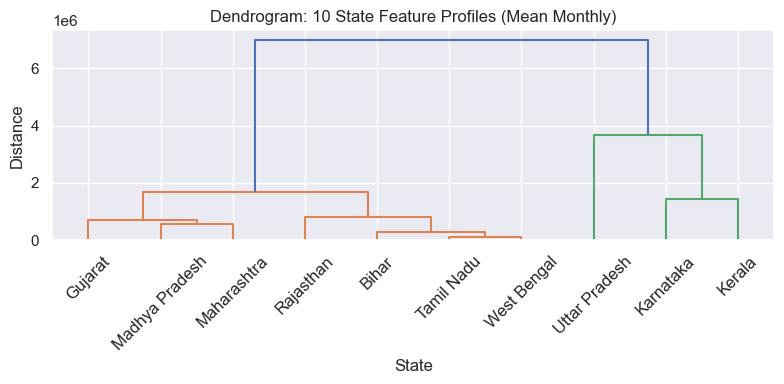

In [9]:
# ============== HIERARCHICAL DENDROGRAM ====================
state_profiles = df_grouped.groupby(state_col)[features].mean()
Z_state = linkage(state_profiles, method="ward")
plt.figure(figsize=(8,4))
dendrogram(Z_state, labels=state_profiles.index, leaf_rotation=45)
plt.title("Dendrogram: 10 State Feature Profiles (Mean Monthly)")
plt.xlabel("State")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()


Logistic Regression Accuracy: 0.971
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       0.95      1.00      0.97        19
           2       1.00      0.92      0.96        12

    accuracy                           0.97        35
   macro avg       0.98      0.97      0.98        35
weighted avg       0.97      0.97      0.97        35



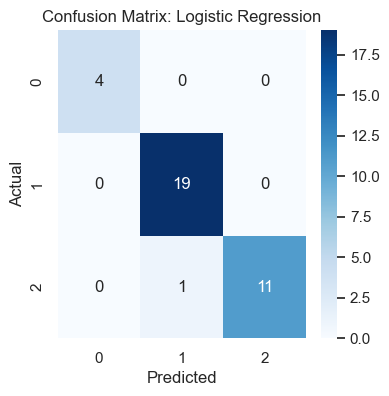

Logistic Regression: 5-Fold CV Accuracy = 0.922

Random Forest Accuracy: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



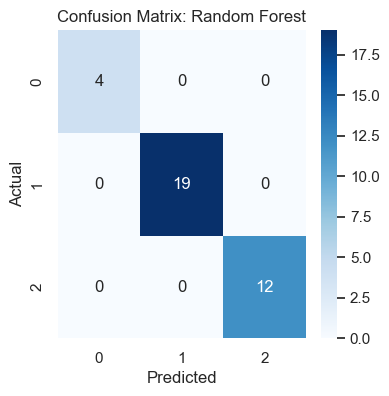

Random Forest: 5-Fold CV Accuracy = 0.957

SVM Accuracy: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



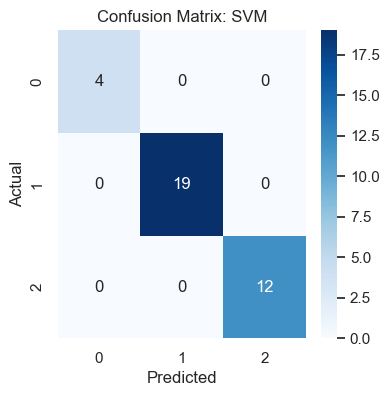

SVM: 5-Fold CV Accuracy = 0.930

XGBoost Accuracy: 1.000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        12

    accuracy                           1.00        35
   macro avg       1.00      1.00      1.00        35
weighted avg       1.00      1.00      1.00        35



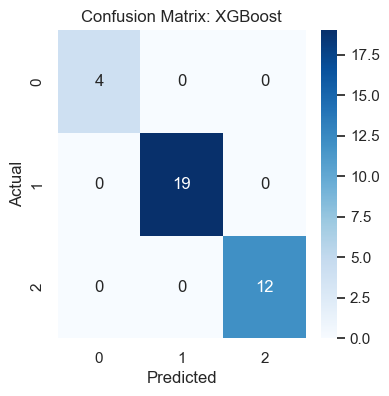

XGBoost: 5-Fold CV Accuracy = 0.939


,Model,Accuracy
0,Logistic Regression,0.971429
1,Random Forest,1.000000
2,SVM,1.000000
3,XGBoost,1.000000


In [10]:
# ====== CLASSIFICATION (Logistic, RF, SVM, XGBoost) =======
X_cls = X_scaled
y_cls = df_grouped["kmeans_cluster"]
Xtr, Xte, ytr, yte = train_test_split(X_cls, y_cls, test_size=0.3, random_state=42, stratify=y_cls)
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "XGBoost": xgb.XGBClassifier(eval_metric="mlogloss")
}
clf_results = []
for name, model in models.items():
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    acc = accuracy_score(yte, pred)
    clf_results.append([name, acc])
    print(f"\n{name} Accuracy: {acc:.3f}")
    print(classification_report(yte, pred))
    cm = confusion_matrix(yte, pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    # Cross-validation
    cvscore = cross_val_score(model, X_cls, y_cls, cv=5).mean()
    print(f"{name}: 5-Fold CV Accuracy = {cvscore:.3f}")
pd.DataFrame(clf_results, columns=["Model", "Accuracy"])

Linear Regression: MAE=0.00, RMSE=0.00, R²=1.000


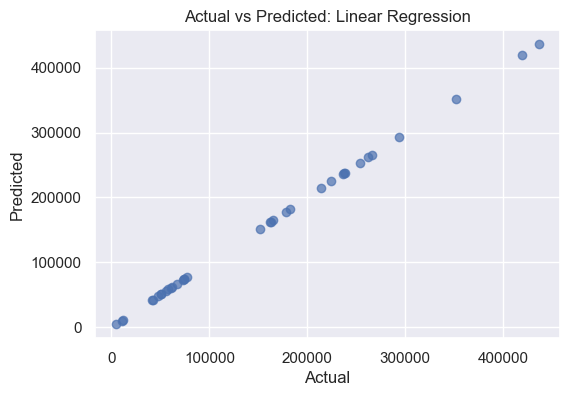

Random Forest: MAE=5421.99, RMSE=11592.34, R²=0.990


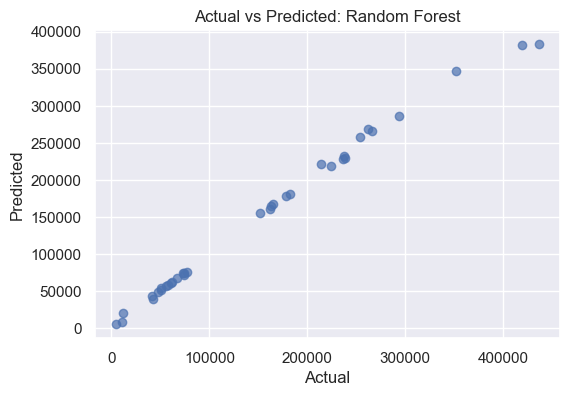

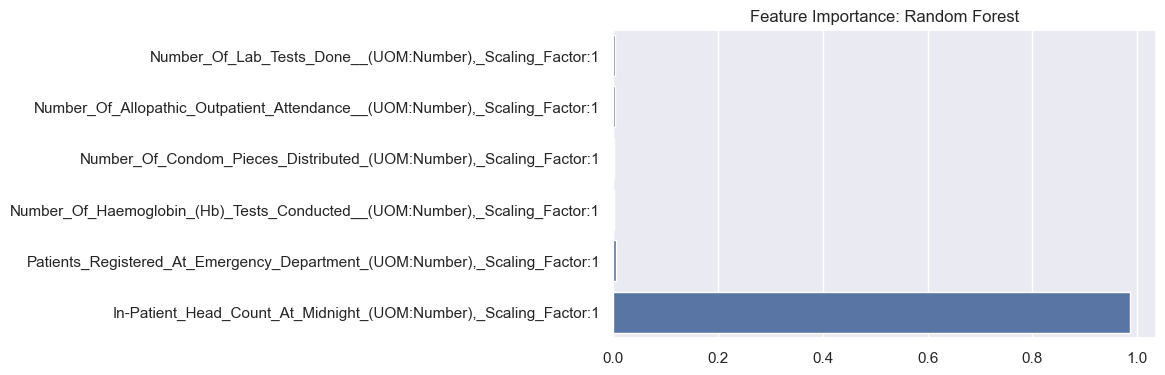

XGBoost: MAE=7115.78, RMSE=11847.85, R²=0.989


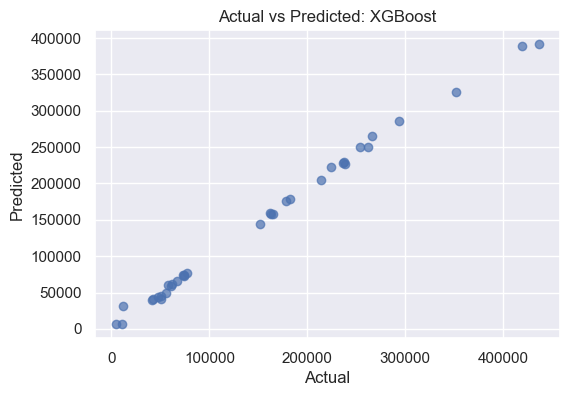

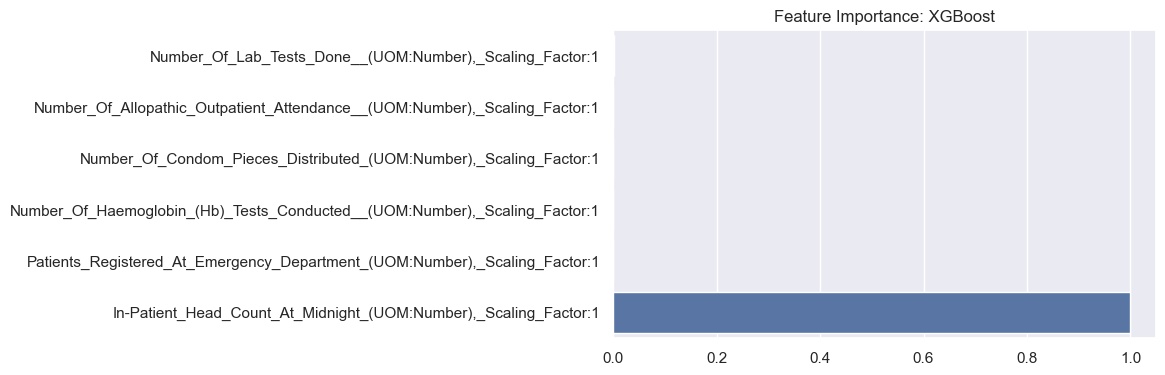

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 172
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 6
[LightGBM] [Info] Start training from score 144212.425977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

C:\Users\91971\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


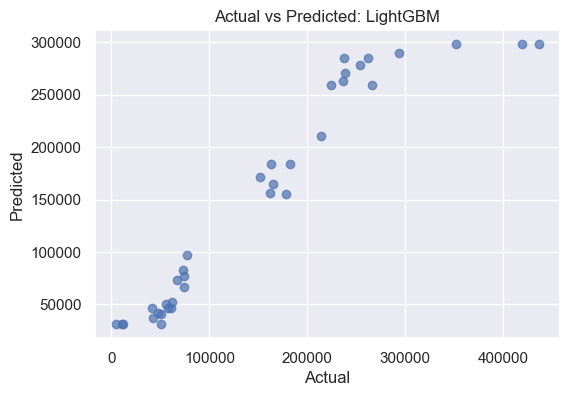

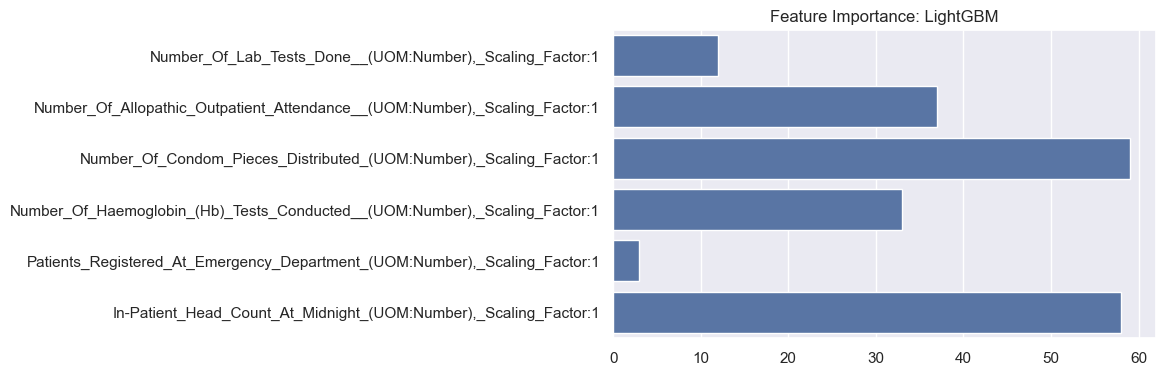

,Model,MAE,RMSE,R²
0,Linear Regression,1.141286e-10,1.738634e-10,1.000000
1,Random Forest,5.421995e+03,1.159234e+04,0.989854
2,XGBoost,7.115779e+03,1.184785e+04,0.989401
3,LightGBM,2.252098e+04,3.691164e+04,0.897128


In [11]:
# ========= REGRESSION (LR, RF, XGBoost, LightGBM) =========
target = 'In-Patient_Head_Count_At_Midnight_(UOM:Number),_Scaling_Factor:1'
Xr = X_scaled
yr = df_grouped[target]
Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(Xr, yr, test_size=0.3, random_state=42)
regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "LightGBM": lgb.LGBMRegressor()
}
reg_results = []
for name, reg in regressors.items():
    reg.fit(Xtr_r, ytr_r)
    pred = reg.predict(Xte_r)
    mae = mean_absolute_error(yte_r, pred)
    rmse = np.sqrt(mean_squared_error(yte_r, pred))
    r2 = r2_score(yte_r, pred)
    reg_results.append([name, mae, rmse, r2])
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.3f}")
    plt.figure(figsize=(6,4))
    plt.scatter(yte_r, pred, alpha=0.7)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {name}")
    plt.show()
    # Feature Importance barplots
    if hasattr(reg, "feature_importances_"):
        plt.figure(figsize=(7,4))
        sns.barplot(x=reg.feature_importances_, y=features)
        plt.title(f"Feature Importance: {name}")
        plt.show()
pd.DataFrame(reg_results, columns=["Model", "MAE", "RMSE", "R²"])

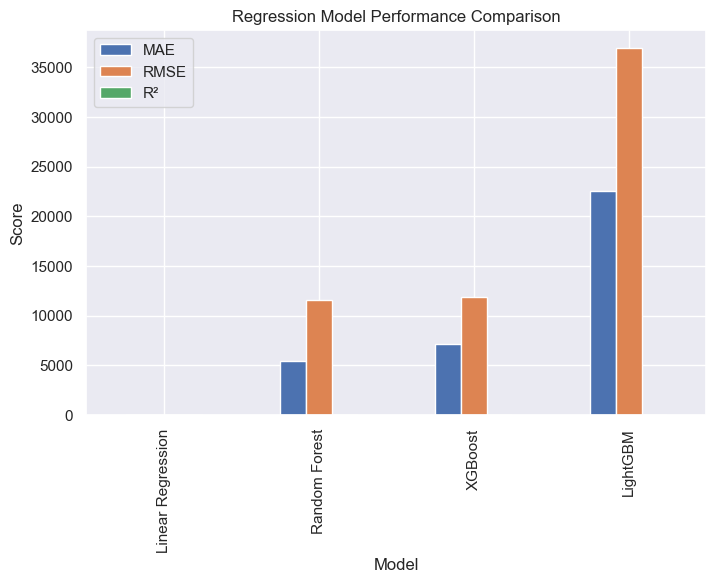

In [12]:
# ==== FINAL PERFORMANCE COMPARISON BAR CHART ====
rf = pd.DataFrame(reg_results, columns=["Model", "MAE", "RMSE", "R²"])
rf.plot(x="Model", y=["MAE","RMSE","R²"], kind="bar", figsize=(8,5))
plt.title("Regression Model Performance Comparison")
plt.ylabel("Score")
plt.show()

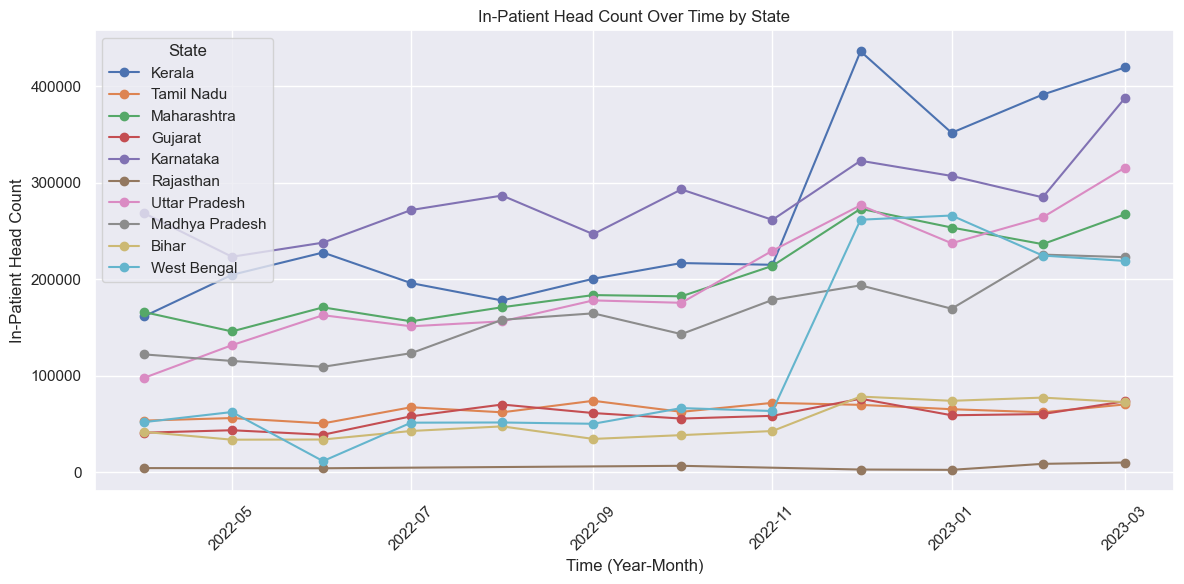

In [13]:
# Time Series Plot for In-Patient Head Count Over Time by State
plt.figure(figsize=(12, 6))
for st in states:
    state_data = df_grouped[df_grouped[state_col] == st]
    plt.plot(state_data['YearMonth'], state_data['In-Patient_Head_Count_At_Midnight_(UOM:Number),_Scaling_Factor:1'],
             marker='o', label=st)

plt.title("In-Patient Head Count Over Time by State")
plt.xlabel("Time (Year-Month)")
plt.ylabel("In-Patient Head Count")
plt.legend(title="State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [14]:
df_maharashtra = df[df[state_col] == "Maharashtra"].copy()
df_maharashtra_grouped = df_maharashtra.groupby('YearMonth')[features].sum().reset_index()


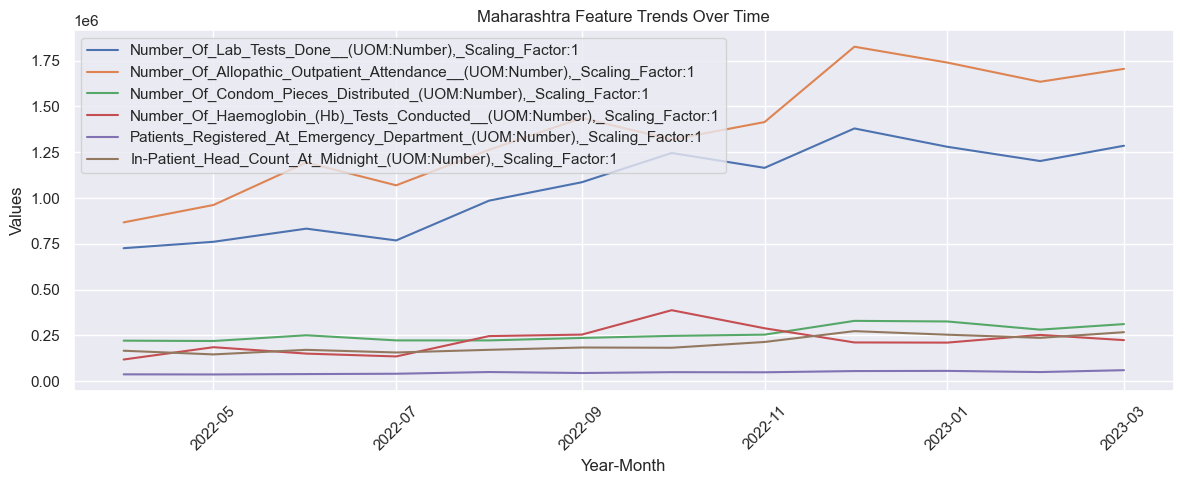

In [15]:
#time series
plt.figure(figsize=(12,5))
for f in features:
    plt.plot(df_maharashtra_grouped['YearMonth'], df_maharashtra_grouped[f], label=f)
plt.title("Maharashtra Feature Trends Over Time")
plt.xlabel("Year-Month")
plt.ylabel("Values")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


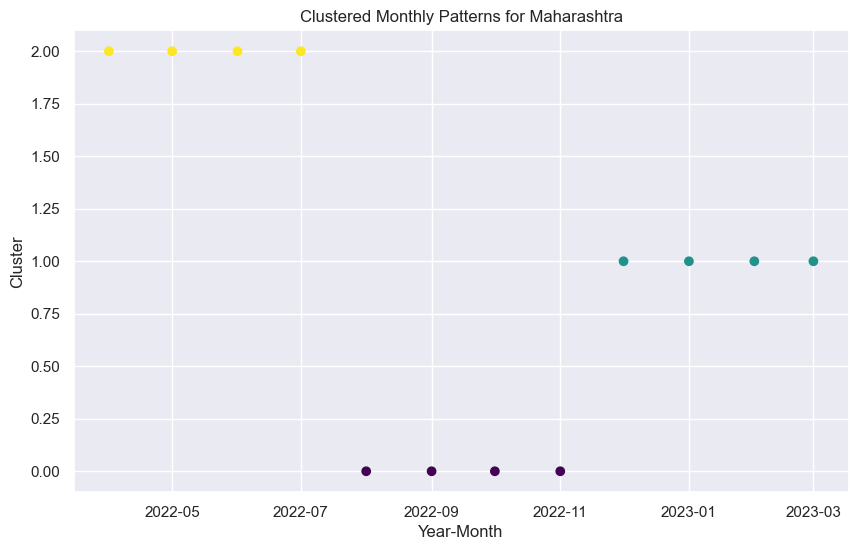

In [16]:
#Clustering Maharashtra Months
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_mah_scaled = scaler.fit_transform(df_maharashtra_grouped[features])

kmeans_mah = KMeans(n_clusters=3, random_state=42)
df_maharashtra_grouped['kmeans_cluster'] = kmeans_mah.fit_predict(X_mah_scaled)

plt.figure(figsize=(10,6))
plt.scatter(df_maharashtra_grouped['YearMonth'], df_maharashtra_grouped['kmeans_cluster'], c=df_maharashtra_grouped['kmeans_cluster'], cmap='viridis')
plt.title("Clustered Monthly Patterns for Maharashtra")
plt.xlabel("Year-Month")
plt.ylabel("Cluster")
plt.show()


In [17]:
#Predictive Modeling (Regression)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X = X_mah_scaled
y = df_maharashtra_grouped['In-Patient_Head_Count_At_Midnight_(UOM:Number),_Scaling_Factor:1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_absolute_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))


MAE: 13528.288750000007
R2 Score: 0.8429860178124804


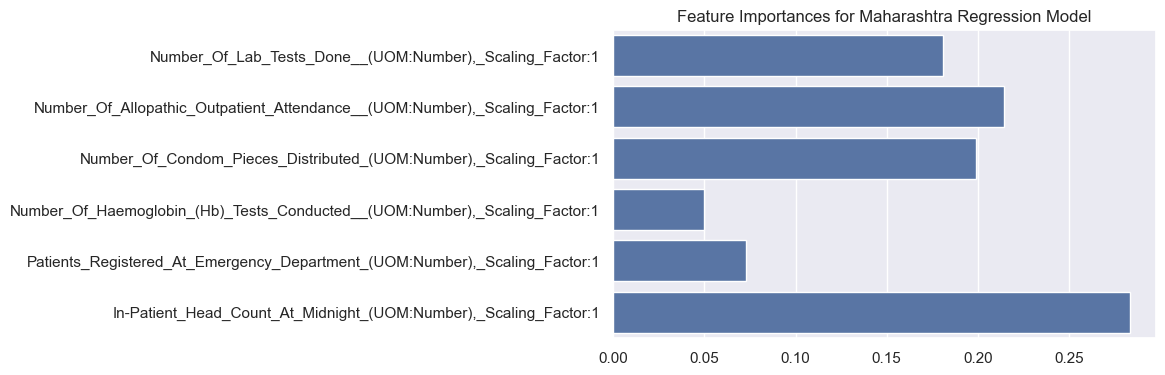

In [18]:
importances = model.feature_importances_
plt.figure(figsize=(7,4))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances for Maharashtra Regression Model")
plt.show()
